<a id='top'></a>
# Exploratory Data Analysis of the FAA Aviation Maintenance Technician Handbook (Vol 1)
### By Daniel Hilgart
A demonstration project of my Exploratory Data Analysis skills applied to an NLP dataset

## Table of Contents
<ul>
<li><a href="#intro">Initial Exploration</a></li>
<li><a href="#cleaning">Data Cleaning</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
    <ul>
        <li><a href="#length">Length distributions</a></li>
        <li><a href="#content">Content distributions</a></li>
        <li><a href="#tf-idf">TF-IDF</a></li>
        <li><a href="#lda">LDA</a></li>
    </ul>
<li><a href="#conclusions">Conclusions & Recommenations</a></li>
</ul>

In [140]:
# pull data from pdf using PyPDF2: https://github.com/mstamy2/PyPDF2
import PyPDF2 as pdf

# PDF sourced from https://www.faa.gov/regulations_policies/handbooks_manuals/aircraft/media/amt_airframe_hb_vol_1.pdf
# Downloaded locally (retrieved on 2021-01-11) to save time
pdf_reader = pdf.PdfFileReader(open('amt_airframe_hb_vol_1.pdf','rb'))

<a id='intro'></a>
## Initial Exploration
<a href="#top">Return to Top</a>

Here I explore the data to determine what type of cleaning may need to be done. Let's start by viewing the document properties:

In [2]:
# View document info:
pdf_reader.getDocumentInfo()

{'/Author': 'FAA',
 '/CreationDate': "D:20180713163736-05'00'",
 '/Creator': 'Adobe InDesign CC 13.1 (Windows)',
 '/ModDate': "D:20180906152458-05'00'",
 '/Producer': 'Adobe PDF Library 15.0',
 '/Title': 'Aviation Maintenance Technician Handbook - Airframe Volume 1',
 '/Trapped': '/False'}

In [3]:
pdf_reader.getNumPages()

584

Nothing too surprising here. The page count (584) matches what I see in my PDF reader.

Upon browsing through the PDF with my PDF reader, I discovered that all of the body text and headings are contained in the bookmarks:
![BodyTextInBookmarks](images/BodyTextInBookmarks.png)
Since common issues in pulling text from PDFs include difficulties with line-breaks, paragraph segmentation, and text being retrieved in the wrong order (e.g. with tables of text contained within figures), I decided to take advantage of these bookmarks to read in the text from the document, bypassing those issues.

I also noticed that all of the text for a given chapter is in a flat structure immediately below the Chapter bookmark. There are some bookmarks that have sub-bookmarks a level down the structure (see yellow highlights below), but they appear to be always empty, so I've ignored them. There also appear to be some entries at the level of the rest of the text that are empty (highlighted in green below), so these will be filtered out.
![SublevelsCanBeIgnored](images/SublevelsCanBeIgnored.png)
You may notice that in the above screenshots, some of the text appears to be cut off. These will be investigated later.

In [4]:
# pull in all of the bookmarks from the document
all_bookmarks = pdf_reader.getOutlines()

I found the all_bookmarks object to be a rather confusing combination of nested lists and dictionaries (as pdf_reader.generic.Destination objects), so I built myself a quick function to help navigate it:

In [5]:
def visualize_level(subbookmarks):
    if type(subbookmarks) == list:
        print(f'type=list, len={len(subbookmarks)}')
    else:
        if '/Title' in subbookmarks.keys():
            print(f'type=Destination, title={subbookmarks["/Title"]}, keys={subbookmarks.keys()}')
        else:
            print(f'type=Destination, keys={subbookmarks.keys()}')

In [6]:
visualize_level(all_bookmarks)

type=list, len=1


In [7]:
#only one element in the list, so we can remove the outer list
all_bookmarks = all_bookmarks[0]

visualize_level(all_bookmarks)

type=list, len=2


We now have a list with two elements. Let's investigate both:

In [8]:
visualize_level(all_bookmarks[0])
visualize_level(all_bookmarks[1])

type=Destination, title=Document, keys=dict_keys(['/Title', '/Page', '/Type', '/Left', '/Top', '/Zoom'])
type=list, len=2


The title of the Destination object matches the top level of the bookmarks hierarchy:
![BookmarksTopLevel](images/BookmarksTopLevel.png)
The other element is another list, again with two elements. Let's look at both elements:

In [9]:
visualize_level(all_bookmarks[1][0])
visualize_level(all_bookmarks[1][1])

type=Destination, title=Article, keys=dict_keys(['/Title', '/Page', '/Type', '/Left', '/Top', '/Zoom'])
type=list, len=2518


looks like the next level down. The list has 2518 elements though. Let's look at the first handful:

In [10]:
for i in range(10):
    print(i)
    visualize_level(all_bookmarks[1][1][i])

0
type=Destination, title=Image, keys=dict_keys(['/Title', '/Page', '/Type', '/Left', '/Top', '/Zoom'])
1
type=Destination, title=FAA-H-8083-31A, keys=dict_keys(['/Title', '/Page', '/Type', '/Left', '/Top', '/Zoom'])
2
type=list, len=6
3
type=Destination, title=Figure, keys=dict_keys(['/Title', '/Page', '/Type', '/Left', '/Top', '/Zoom'])
4
type=Destination, title=Acknowledgments, keys=dict_keys(['/Title', '/Page', '/Type', '/Left', '/Top', '/Zoom'])
5
type=list, len=151
6
type=Destination, title=Preface, keys=dict_keys(['/Title', '/Page', '/Type', '/Left', '/Top', '/Zoom'])
7
type=list, len=8
8
type=Destination, title=Volume Contents, keys=dict_keys(['/Title', '/Page', '/Type', '/Left', '/Top', '/Zoom'])
9
type=list, len=85


Those entries with sub-entries in the hierarchy have 2 elements in the list, a Destination object and a list object. Those without sub-entries only have a destination.

Let's find the entry for Chapter 1:

In [11]:
i = 0
bFound = False
while bFound == False:
    if type(all_bookmarks[1][1][i]) == pdf.generic.Destination:
        if all_bookmarks[1][1][i]['/Title'] == 'Chapter 1':
            bFound = True
            break
    i+=1
print(i)
visualize_level(all_bookmarks[1][1][i])

16
type=Destination, title=Chapter 1, keys=dict_keys(['/Title', '/Page', '/Type', '/Left', '/Top', '/Zoom'])


Found it! The Destination object is element 16, which means the corresponding list object should be at the next element, 17:

In [12]:
visualize_level(all_bookmarks[1][1][17])

type=list, len=288


Looks promising. Let's look at the first handful of entries for element 17 to confirm they are from Chapter 1:

In [13]:
for i in range(20):
    print(i)
    visualize_level(all_bookmarks[1][1][17][i])

0
type=Destination, title=Chapter 1, keys=dict_keys(['/Title', '/Page', '/Type', '/Left', '/Top', '/Zoom'])
1
type=list, len=1
2
type=Destination, title=Aircraft Structures, keys=dict_keys(['/Title', '/Page', '/Type', '/Left', '/Top', '/Zoom'])
3
type=Destination, title=A Brief History of Aircraft Structures, keys=dict_keys(['/Title', '/Page', '/Type', '/Left', '/Top', '/Zoom'])
4
type=Destination, title=The history of aircraft structures underlies the history of aviation in general. Advances in materials and processes used to construct aircraft have led to their evolution from simple wood truss structures to the sleek aerodynamic flying machines of today. Combined with continuous powerplant development, the structures of “flying machines” have changed significantly., keys=dict_keys(['/Title', '/Page', '/Type', '/Left', '/Top', '/Zoom'])
5
type=Destination, title=The key discovery that “lift” could be created by passing air over the top of a curved surface set the development of fixed 

Yes, these elements correspond to the Chapter 1 elements in the screenshot above. As noted before, some of the text seems to be cut off (Elements 8, 11, and 18). Let's investigate further to see if they are cut off in the same place:

In [14]:
for i in [8,11,18]:
    print(len(all_bookmarks[1][1][17][i]['/Title']))

512
512
512


They are all 512 characters long. This is good as we can easily identify which paragraphs have been cut off and will need to be cleaned. Most of the paragraphs are less than 512 characters, and those that are longer are not missing a ton of data, so in the spirit of rapid iteration and feedback, I will capture the action of cleaning these paragraphs for potential future work in the recommendations section below.

<a id='cleaning'></a>
## Data Cleaning
<a href="#top">Return to Top</a>

Based on the exploration above, I will pull the body text from the bookmarks object, storing each paragraph as a row in a Pandas dataframe. I will also store in a separate column the Chapter number from which the paragraph came. In this format, more detailed exploration and analysis can be conducted.

In [15]:
# Use pandas (https://pandas.pydata.org/) for the Dataframe:
import pandas as pd

First, for each chapter, find the list object that contains the body text for that chapter:

In [16]:
chapters = []
for i, element in enumerate(all_bookmarks[1][1]):
    if type(element) == list:
        # Check if the previous element is the Destination object for a Chapter:
        if 'Chapter' in all_bookmarks[1][1][i-1]['/Title']:
            #if so, append the list element to the chapters list
            chapters.append(element)

print(len(chapters)) # Per the table of contents, this should be 9

9


Looks like we successfully found all the chapters. Now, let's add their body text to a dataframe:

In [17]:
%%time 

df = pd.DataFrame()
for chapter_id, chapter in enumerate(chapters):
    for element_id, element in enumerate(chapter):
        if type(element) == pdf.generic.Destination:
            if element['/Title'] != ' ': # filtering out empty text as noted above
                df = df.append(pd.Series({'Chapter':chapter_id + 1,
                                          'Element':element_id, # in case we need to find the Destination object again later
                                          'Paragraph':str(element['/Title']) # need to convert from TextStringObject to str
                                         }),ignore_index=True)
df = df.astype({'Chapter':int,'Element':int})

Wall time: 10.5 s


Now let's tokenize the text into words. For this I'll use spaCy (https://spacy.io/).

In [18]:
%%time 

# spaCy from https://spacy.io/:
import spacy
nlp = spacy.load("en_core_web_lg") # if OSError: [E050] Can't find model 'en_core_web_lg', run this from command line:
                                   # 'python -m spacy download en_core_web_lg'
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
from string import punctuation

Wall time: 5.81 s


In [19]:
%%time

df['Tokens']=df['Paragraph'].apply(lambda x: [token for token in nlp(x)])

Wall time: 53.5 s


Let's add another column that removes stopwords and lemmatizes:

In [20]:
def lemmatize(tokens):
    """
    Lemmatizes the text, removes stop words and punctuation, converts to str, and lowercases
    """
    return [str(token.lemma_).lower() for token in tokens if (not token.is_stop) 
                                           and (not str(token) in punctuation)]

df['Lemmas']=df['Tokens'].apply(lambda x: lemmatize(x))

Let's divide the text into sentences as well:

In [21]:
%%time

nlp.add_pipe(nlp.create_pipe('sentencizer'))

df['Sents']=df['Paragraph'].apply(lambda x: [sent for sent in nlp(x).sents])

Wall time: 51.4 s


Let's take a look at our df:

In [22]:
df.shape

(5201, 6)

In [23]:
df.head(10)

,Chapter,Element,Paragraph,Tokens,Lemmas,Sents
0,1,0,Chapter 1,"[Chapter, 1]","[chapter, 1]","[(Chapter, 1)]"
1,1,2,Aircraft Structures,"[Aircraft, Structures]","[aircraft, structure]","[(Aircraft, Structures)]"
2,1,3,A Brief History of Aircraft Structures,"[A, Brief, History, of, Aircraft, Structures]","[brief, history, aircraft, structure]","[(A, Brief, History, of, Aircraft, Structures)]"
3,1,4,The history of aircraft structures underlies t...,"[The, history, of, aircraft, structures, under...","[history, aircraft, structure, underlie, histo...","[(The, history, of, aircraft, structures, unde..."
4,1,5,The key discovery that “lift” could be created...,"[The, key, discovery, that, “, lift, ”, could,...","[key, discovery, "", lift, "", create, pass, air...","[(The, key, discovery, that, “, lift, ”, could..."
5,1,6,"Earlier, Cayley studied the center of gravity ...","[Earlier, ,, Cayley, studied, the, center, of,...","[early, cayley, study, center, gravity, fly, m...","[(Earlier, ,, Cayley, studied, the, center, of..."
6,1,7,"In the late 1800s, Otto Lilienthal built upon ...","[In, the, late, 1800s, ,, Otto, Lilienthal, bu...","[late, 1800, otto, lilienthal, build, cayley, ...","[(In, the, late, 1800s, ,, Otto, Lilienthal, b..."
7,1,8,"Octave Chanute, a retired railroad and bridge ...","[Octave, Chanute, ,, a, retired, railroad, and...","[octave, chanute, retire, railroad, bridge, en...","[(Octave, Chanute, ,, a, retired, railroad, an..."
8,1,10,The work of all of these men was known to the ...,"[The, work, of, all, of, these, men, was, know...","[work, man, know, wright, brothers, build, suc...","[(The, work, of, all, of, these, men, was, kno..."
9,1,11,Powered heavier-than-air aviation grew from th...,"[Powered, heavier, -, than, -, air, aviation, ...","[powered, heavy, air, aviation, grow, wright, ...","[(Powered, heavier, -, than, -, air, aviation,..."


In [24]:
# look at a random sample to see if anything in the middle might have a problem:
df.sample(20, random_state=61)

,Chapter,Element,Paragraph,Tokens,Lemmas,Sents
3780,8,7,Internal structure and unexposed components ar...,"[Internal, structure, and, unexposed, componen...","[internal, structure, unexposed, component, fi...","[(Internal, structure, and, unexposed, compone..."
2013,4,920,Step 1: Adjustment of Bend Radius,"[Step, 1, :, Adjustment, of, Bend, Radius]","[step, 1, adjustment, bend, radius]","[(Step, 1, :, Adjustment, of, Bend, Radius)]"
4303,9,205,X = 1,"[X, =, , 1]","[x, , 1]","[(X, =, , 1)]"
1692,4,550,4. If the rivet head does not come loose of it...,"[4, ., If, the, rivet, head, does, not, come, ...","[4, rivet, head, come, loose, accord, insert, ...","[(4, .), (If, the, rivet, head, does, not, com..."
3533,7,420,Use a flexible disk sander or a rotating pad s...,"[Use, a, flexible, disk, sander, or, a, rotati...","[use, flexible, disk, sander, rotate, pad, san...","[(Use, a, flexible, disk, sander, or, a, rotat..."
235,1,266,Rigid Rotor System,"[Rigid, Rotor, System]","[rigid, rotor, system]","[(Rigid, Rotor, System)]"
790,2,553,2. The aircraft must be in a condition for saf...,"[2, ., The, aircraft, must, be, in, a, conditi...","[2, aircraft, condition, safe, operation, refe...","[(2, .), (The, aircraft, must, be, in, a, cond..."
4075,8,318,Remove metal decals by moistening the edge of ...,"[Remove, metal, decals, by, moistening, the, e...","[remove, metal, decal, moisten, edge, foil, al...","[(Remove, metal, decals, by, moistening, the, ..."
1538,4,387,Installation of Rivets,"[Installation, of, Rivets]","[installation, rivets]","[(Installation, of, Rivets)]"
3654,7,551,Cherry’s E-Z Buck (CSR90433) Hollow Rivet,"[Cherry, ’s, E, -, Z, Buck, (, CSR90433, ), Ho...","[cherry, e, z, buck, csr90433, hollow, rivet]","[(Cherry, ’s, E, -, Z, Buck, (, CSR90433, ), H..."


We have 5201 paragraphs from the 9 chapters. The head of the df corresponds to what we saw when we explored the first few elements of Chapter 1, so that looks good. The random sample shows a few interesting paragraphs including a few section headers, a couple bullet points (likely from bulleted lists), a few numbered items (likely from ordered lists), and an equation ('X = 1').

Let's grab the Chapter Headings into a list as it might be useful to know the title of each chapter as we get into the analysis:

In [105]:
chapter_headings = []
for index, text in df['Paragraph'].iteritems():
    if 'Chapter' == text[:len('Chapter')]:
        chapter_headings.append(f'{text}: {df.loc[index+1,"Paragraph"]}')
chapter_headings

['Chapter 1: Aircraft Structures',
 'Chapter 2: Aerodynamics, Aircraft ',
 'Chapter 3: Aircraft Fabric Covering',
 'Chapter 4: Aircraft Metal Structural Repair',
 'Chapter 5: Aircraft Welding',
 'Chapter 6: Aircraft Wood ',
 'Chapter 7: Advanced Composite Materials',
 'Chapter 8: Aircraft Painting and Finishing',
 'Chapter 9: Aircraft Electrical System']

Hmm, looks like Chapters 2 and 6 are missing the end of the title (see the screnshot from the TOC below). This is something that could be investigated in a future phase, but for now we will just fix them manually:
![ChapterTitles](images/ChapterTitles.png)

In [106]:
chapter_headings[1]+= 'Assembly, and Rigging'
chapter_headings[5]+= 'and Structural Repair'
chapter_headings

['Chapter 1: Aircraft Structures',
 'Chapter 2: Aerodynamics, Aircraft Assembly, and Rigging',
 'Chapter 3: Aircraft Fabric Covering',
 'Chapter 4: Aircraft Metal Structural Repair',
 'Chapter 5: Aircraft Welding',
 'Chapter 6: Aircraft Wood and Structural Repair',
 'Chapter 7: Advanced Composite Materials',
 'Chapter 8: Aircraft Painting and Finishing',
 'Chapter 9: Aircraft Electrical System']

That's better.

The data looks fairly clean (with the exception of the 512 character limitation mentioned above). We are ready to proceed.

<a id='eda'></a>
## Exploratory Data Analysis
<a href="#top">Return to Top</a>

In [180]:
# I will use matplotlib (https://matplotlib.org/) and seaborn (https://seaborn.pydata.org/) for visualizations:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<a id='length'></a>
### Length distributions:
<a href="#top">Return to Top</a>

First I'll investigate distributions of lengths of various quantities without taking the actual content into account. That will come later.
Let's start by looking at paragraphs per chapter:

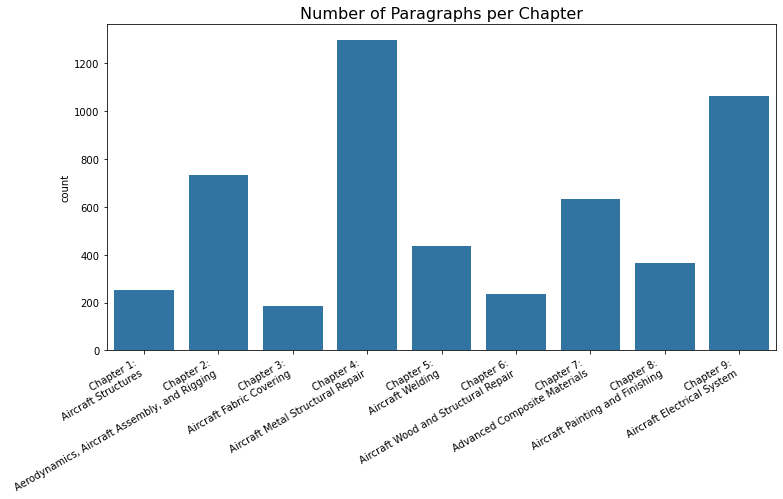

In [126]:
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(df['Chapter'], color='C0')
plt.title('Number of Paragraphs per Chapter', fontsize = 16)
plt.xlabel('')
ax.set_xticks([i for i in range(9)])
ax.set_xticklabels([x.replace(': ',':\n') for x in chapter_headings], rotation=30, ha='right');

Chapter 4 has the most paragraphs. Chapter 3 has the least.

Next, let's look at the distribution of number of words (lemmas) per chapter:

In [27]:
#Here I'll introduce a function I can use to prepare visualiztions to be grouped by chapter:
def groupby_chapter(df,column_name,func):
    """
    Applies a function to the column_name and returns a groupby object, grouped by chapter.
    The applied function is in a column named 'Func'
    """
    temp_df = pd.concat([df,df[column_name].apply(func).rename('Func')],axis=1)
    temp_df = temp_df.groupby('Chapter')['Func']
    
    return temp_df

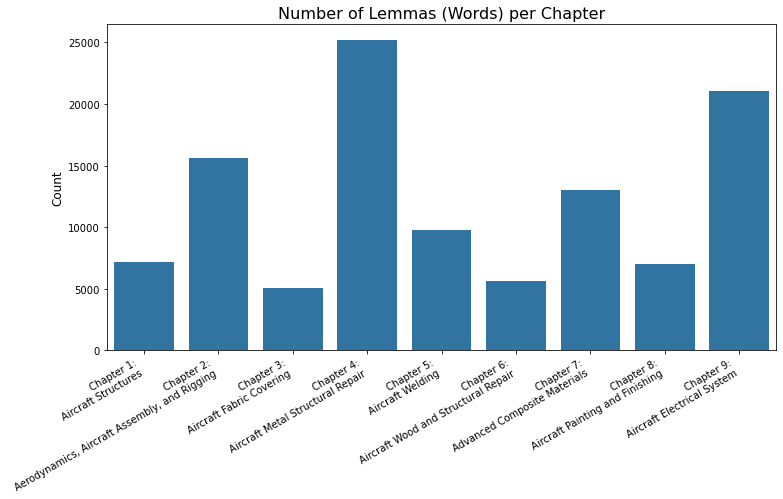

In [128]:
plot_df = groupby_chapter(df,'Lemmas',lambda x: len(x)).sum()

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(plot_df.index,plot_df, color='C0')
plt.title('Number of Lemmas (Words) per Chapter', fontsize = 16)
plt.xlabel('')
plt.ylabel('Count', fontsize = 12)
ax.set_xticks([i for i in range(9)])
ax.set_xticklabels([x.replace(': ',':\n') for x in chapter_headings], rotation=30, ha='right');

The word counts closely resemble the paragraph counts.

Next, let's look at the distribution of paragraph character lengths:

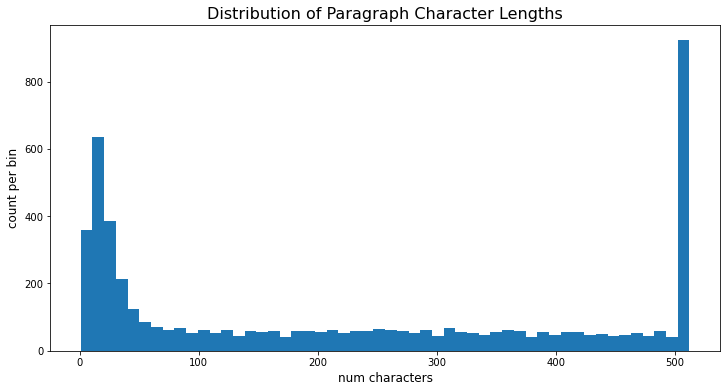

In [29]:
fig, ax = plt.subplots(figsize=(12,6))
plt.hist(df['Paragraph'].apply(lambda x: len(x)),bins=52)
plt.title('Distribution of Paragraph Character Lengths', fontsize = 16)
plt.xlabel('num characters', fontsize = 12)
plt.ylabel('count per bin', fontsize = 12);

There are a number of shorter paragraphs (< 50 characters). From 50 to 500, the length distribution looks surprisingly uniform. There is a large spike north of 500 which probably corresponds to the paragraphs that have been cut-off at 512 characters as discovered above.

What % of the paragraphs have been cut off?

In [30]:
print(f'{sum(df["Paragraph"].apply(lambda x: len(x)) == 512) / df.shape[0]:.1%}')

17.0%


Next, let's look at the distribution of paragraph word lengths:

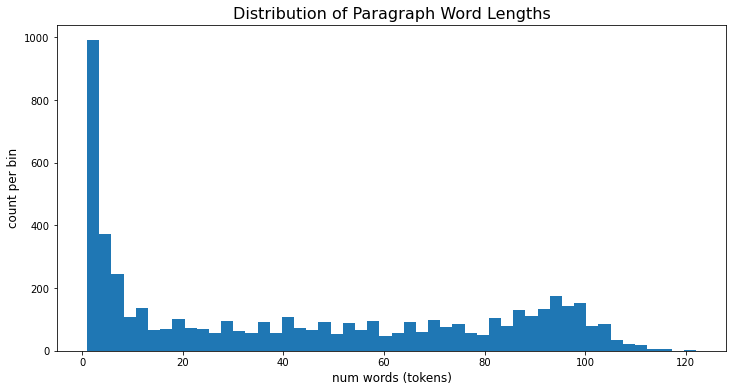

In [31]:
fig, ax = plt.subplots(figsize=(12,6))
plt.hist(df['Tokens'].apply(lambda x: len(x)),bins=50)
plt.title('Distribution of Paragraph Word Lengths', fontsize = 16)
plt.xlabel('num words (tokens)', fontsize = 12)
plt.ylabel('count per bin', fontsize = 12);

Again, we see a number of shorter paragraphs followed by a relatively flat distribution for most of the middle. At the tail end of the distribution there appears to be a bit of a normal distribution superimposed corresponding to the distribution of word counts for the cut-off 512-character paragraphs (the 512-character paragraph word counts appear to range from 80 to 110 with just a handful > 110).

Next, let's look at sentences per paragraph:

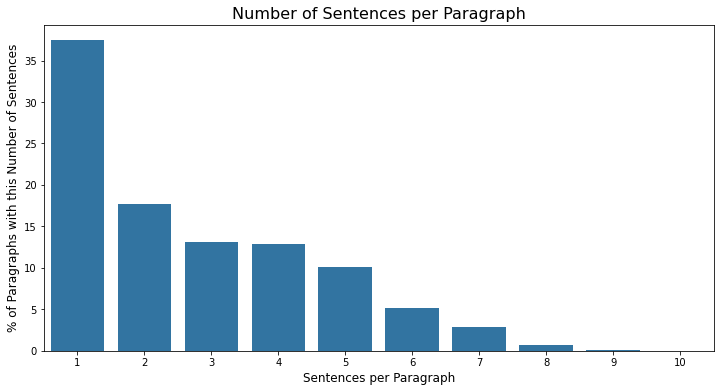

In [32]:
plot_df = df['Sents'].apply(lambda x: len(x)).value_counts(normalize=True).mul(100)

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(plot_df.index,plot_df, color='C0')
plt.title('Number of Sentences per Paragraph', fontsize = 16)
plt.xlabel('Sentences per Paragraph', fontsize = 12)
plt.ylabel('% of Paragraphs with this Number of Sentences', fontsize = 12);

Nothing too surprising here. Let's see if there are variations between chapters:

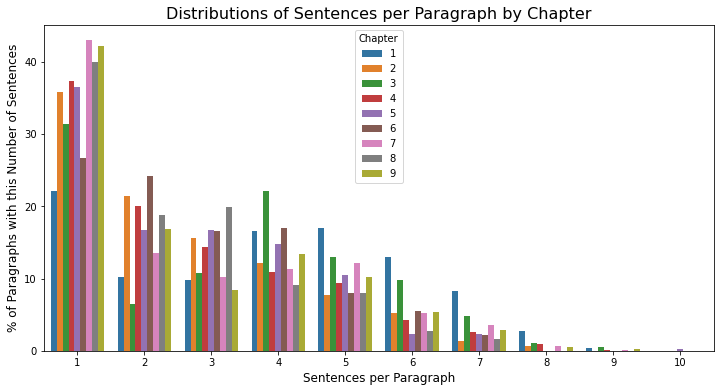

In [112]:
plot_df = groupby_chapter(df,'Sents',lambda x: len(x)).value_counts(normalize=True).mul(100).rename('percent')
plot_df = plot_df.reset_index().rename({'Func':'Num Sents'},axis=1)

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x=plot_df['Num Sents'],y=plot_df['percent'],hue=plot_df['Chapter'])
plt.title('Distributions of Sentences per Paragraph by Chapter', fontsize = 16)
plt.xlabel('Sentences per Paragraph', fontsize = 12)
plt.ylabel('% of Paragraphs with this Number of Sentences', fontsize = 12);

The shortest chapters; chapters 1, 3, and (to a lesser extent) 6; tend to have paragraphs with more sentences than the longer chapters.

<a id='content'></a>
### Content distributions:
<a href="#top">Return to Top</a>

Next I'll start looking into word counts:

In [34]:
# lemmas have had punctuation and stop words removed.
all_lemmas = []
for paragraph in df['Lemmas']:
    for lemma in paragraph:
        all_lemmas.append(lemma)

top_lemmas = pd.Series(all_lemmas).value_counts()[:20]
top_lemmas

aircraft    1433
repair       760
material     753
figure       744
metal        741
rivet        658
surface      643
control      602
use          543
type         505
system       504
form         469
wing         450
•            444
fabric       437
wire         418
hole         409
area         406
edge         406
current      403
dtype: int64

'aircraft' has nearly double the occurances of the second most common word, 'repair'. Interestingly, a bulletpoint is one of the top 20 most common 'words': there are lots of bulleted lists in the document. Nothing else is too surprising here.

Let's see how this breaks down by chapter:

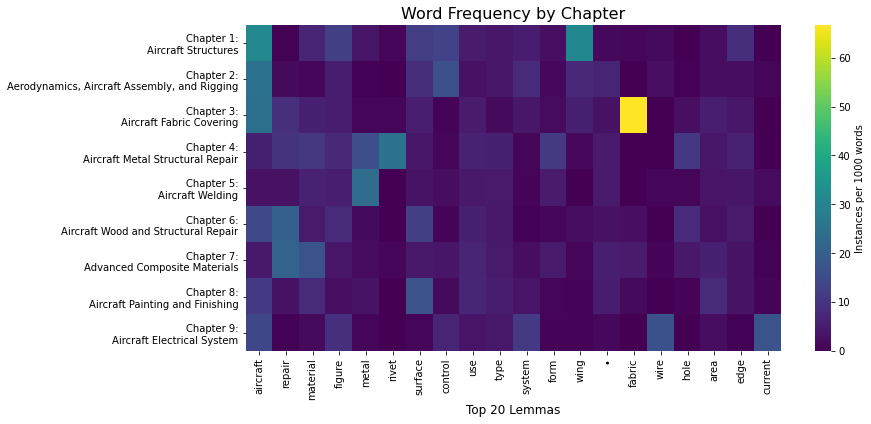

In [131]:
lemma_counts_df = pd.DataFrame(index=top_lemmas.index,columns=[f'Chapter {i}' for i in range(1,9+1)],data=0)
for index, row in df.iterrows():
    for lemma in row['Lemmas']:
        if lemma in lemma_counts_df.index:
            lemma_counts_df.loc[lemma,f'Chapter {row["Chapter"]}']+=1

total_chapter_lemma_counts = groupby_chapter(df,'Lemmas',lambda x: len(x)).sum()
total_chapter_lemma_counts.index = [f'Chapter {i}' for i in range(1,9+1)]

instances_per_1000_words = 1000 * lemma_counts_df / total_chapter_lemma_counts

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(instances_per_1000_words.T, cmap='viridis', cbar_kws={'label': 'Instances per 1000 words'})
plt.title('Word Frequency by Chapter', fontsize = 16)
plt.xlabel('Top 20 Lemmas', fontsize = 12)
ax.set_yticks([i+0.5 for i in range(9)])
ax.set_yticklabels([x.replace(': ',':\n') for x in chapter_headings], ha='right');

Interesting! The word fabric dominates chapter 3, which makes sense considering the title of this Chapter is 'Aircraft Fabric Covering'

It's hard to see the rest of the distributions with this one point throwing the color scale off. Let's rescale and try again:

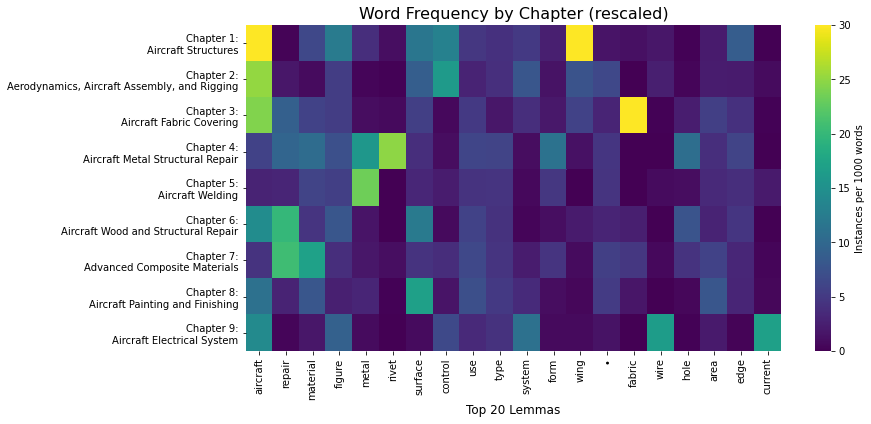

In [132]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(instances_per_1000_words.T, vmax = 30, cmap='viridis', cbar_kws={'label': 'Instances per 1000 words'})
plt.title('Word Frequency by Chapter (rescaled)', fontsize = 16)
plt.xlabel('Top 20 Lemmas', fontsize = 12)
ax.set_yticks([i+0.5 for i in range(9)])
ax.set_yticklabels([x.replace(': ',':\n') for x in chapter_headings], ha='right');

Some interesting observations here:
 - Many of the top 20 words appear prominently in a single chapter: 
     - 'wing' in Chapter 1 (Aircraft Structures)
     - 'fabric' in Chapter 3 (Aircraft Fabric Covering)
     - 'rivet' in Chapter 4 (Aircraft Metal Structural Repair)
     - 'metal' in Chapter 5 (Aircraft Welding), but also in Chapter 4
     - 'wire' and 'current' in Chapter 9 (Aircraft Electrical System)
 - The rest are more evenly distributed throughout. Notably, the following words have very uniform distributions:
     - 'material'
     - 'figure' (each chapter appears to have a similar proportion of pictures)
     - 'use'
     - 'type'
     - the bullet point (no chapter seems to make significantly more use of lists than the others)
     - 'edge'
     - 'area'
 - Most chapters appear to have one or two key words that are more prominent than the rest
 - The word 'aircraft' is quite prominent in the first 3 chapters
 
Next, let's take a look at bigrams:

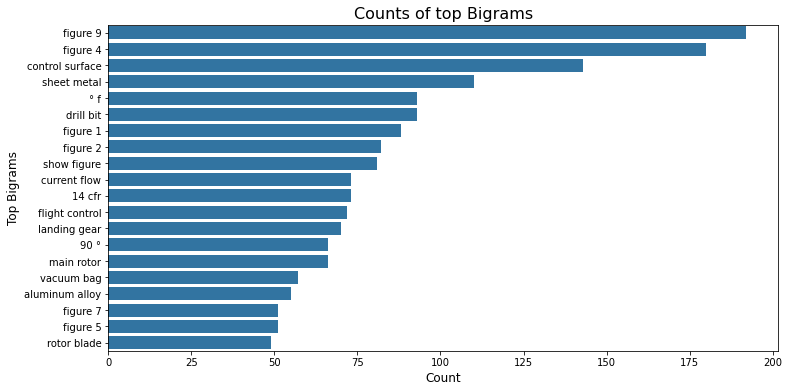

In [143]:
def generate_ngrams(tokens,n):
    ngrams=[]
    lemmas = lemmatize(tokens)
    for i in range(len(lemmas)-n+1):
        ngram=lemmas[i]
        for j in range(n-1):
            ngram += f' {lemmas[i+1+j]}'
        ngrams.append(ngram)
    return ngrams

bigrams = []
for sents in df['Sents']:
    for sent in sents:
        bigrams+=generate_ngrams(sent,2)
        
top_bigrams = pd.Series(bigrams).value_counts()[:20]


fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(top_bigrams,top_bigrams.index, color='C0')
plt.title('Counts of Top Bigrams', fontsize = 16)
plt.xlabel('Count', fontsize = 12)
plt.ylabel('Top Bigrams', fontsize = 12);

At first it might be surprising that Figure 9 and Figure 4 show up much more frequently than the lower figure numbers, but checking the document, we see that the digit immediately following the word figure refers to the chapter (e.g. Figure 9-1). Therefore, this means that chapters 9 and 4 have the most figures.

The other common bigrams all make sense for an aircraft manual.

Let's check trigrams as well:

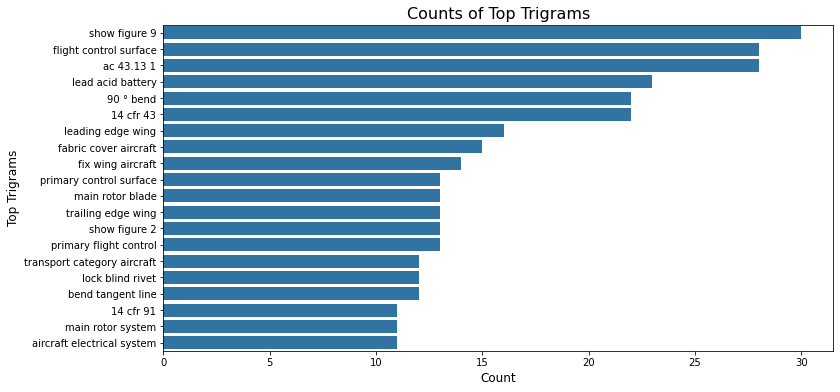

In [145]:
trigrams = []
for sents in df['Sents']:
    for sent in sents:
        trigrams+=generate_ngrams(sent,3)
        
top_trigrams = pd.Series(trigrams).value_counts()[:20]


fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(top_trigrams,top_trigrams.index, color='C0')
plt.title('Counts of Top Trigrams', fontsize = 16)
plt.xlabel('Count', fontsize = 12)
plt.ylabel('Top Trigrams', fontsize = 12);

The counts are starting to get lower. Some other observations:
- 'Show figure 9' probably corresponds to 'As shown in Figure 9-' after lemmatization. 
- ac 43.13 1 and 14 cfr 43 look like titles of regulations. 
- The remaining trigrams all make sense for an aircraft manual.

Next, let's move on to...
<a id='tf-idf'></a>
### TF-IDF
<a href="#top">Return to Top</a>

I'm going to define each chapter as a document so we can find the most significant terms for each chapter.

In [69]:
# I'm going to use TF-IDF from scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html):
from sklearn.feature_extraction.text import TfidfVectorizer

In [148]:
%%time

# Populate all_docs from the un-tokenized column of the df
all_docs = ['' for i in range(9)]
for index, row in df.iterrows():
    all_docs[row['Chapter']-1] += f'{row["Paragraph"]} '

    
# TfidfVectorizer requires a specific format for the tokenizer, so I wrote a function that incorporates the lemmatize 
# function I wrote above:
def spacy_tokenizer(doc):
    return lemmatize([x for x in nlp(doc)])
vectorizer = TfidfVectorizer(lowercase = True,
                             tokenizer = spacy_tokenizer,
                             stop_words = spacy_stopwords,
                             ngram_range = (1,1),
                             use_idf = True
                            )
df_tf_idf = pd.DataFrame(vectorizer.fit_transform(all_docs).toarray(),
                         columns=vectorizer.get_feature_names(),
                         index=chapter_headings
                        )

Wall time: 33.9 s


In [149]:
num_terms = 20
display_df = pd.DataFrame(index = [i+1 for i in range(num_terms)], 
                          columns=pd.MultiIndex.from_product([chapter_headings,['Term','TF-IDF score']])
                         )

for index, row in df_tf_idf.iterrows():
    terms = row.sort_values(ascending=False)[:num_terms]
    for i, (term, score) in enumerate(terms.iteritems()):
        display_df.loc[i+1,(index,'Term')] = term
        display_df.loc[i+1,(index,'TF-IDF score')] = score
display_df

Chapter 1: Aircraft Structures               \
                             Term TF-IDF score   
1                        aircraft      0.41278   
2                            wing     0.407325   
3                           rotor     0.181652   
4                               1     0.170931   
5                         control     0.170931   
6                          figure     0.161839   
7                         surface     0.156384   
8                            spar     0.138548   
9                        fuselage     0.127289   
10                         flight     0.125817   
11                         design     0.125471   
12                           flap      0.12233   
13                            rib     0.115387   
14                           edge      0.11456   
15                                    0.109105   
16                     helicopter     0.108023   
17                           tail     0.106081   
18                        aileron    0.0954442   
19                           gear    0.0924602   
20                         engine    0.0909208   

   Chapter 2: Aerodynamics, Aircraft Assembly, and Rigging               \
                                                      Term TF-IDF score   
1                                            aircraft          0.368286   
2                                               rotor          0.314962   
3                                             control          0.240513   
4                                                              0.210449   
5                                          helicopter          0.181837   
6                                              flight          0.175895   
7                                          inspection          0.162005   
8                                               cable          0.145942   
9                                               blade          0.145305   
10                                               drag          0.142229   
11                                            program          0.138628   
12                                            surface          0.129652   
13                                             system          0.123075   
14                                               lift          0.119317   
15                                               wing          0.111801   
16                                                air          0.110862   
17                                              force          0.106164   
18                                             thrust          0.102621   
19                                             engine          0.102406   
20                                                  2         0.0995875   

   Chapter 3: Aircraft Fabric Covering               \
                                  Term TF-IDF score   
1                               fabric     0.769012   
2                             aircraft     0.206275   
3                             covering     0.195666   
4                                 dope     0.170022   
5                                  stc     0.160684   
6                                  rib     0.131752   
7                                cover     0.129131   
8                            polyester      0.12212   
9                              process     0.120746   
10                              lacing    0.0960994   
11                              cotton     0.089983   
12                             coating     0.087125   
13                                        0.0804975   
14                             approve    0.0778564   
15                              repair    0.0771434   
16                                tape    0.0722952   
17                            strength    0.0704353   
18                                seam    0.0624681   
19                               apply    0.0574654   
20                              finish     0.053758   

   Chapter 4: Aircraft Metal Structural 

The TF-IDF analysis picks up on some of the same terms that were highlighted in the Word Frequency heatmap. For example, it shows that 'fabric' is by far the most significant word (.77 score vs the next closest, 'glue' in Chapter 6 at 0.53). It also shows that 'aircraft' is especially important in Chapters 1-3 compared to the rest of the chapters.

However, it also picks up some terms that were not present in the top 20 terms:
- 'rotor' in Chapter 2 (Aerodynamics, Aircraft Assembly, and Rigging) and to a lesser extent in Chapter 1 (Aircraft Structures)
- 'weld', 'welding', and 'torch' in Chapter 5 (Aircraft Welding)
- 'glue' and 'wood' in Chapter 6 (Aircraft Wood and Structural Repair)
- 'resin', 'cure', 'ply', 'composite', and 'vacuum' in Chapter 7 (Advanced Composite Materials)
- 'paint', 'spray', 'decal', and 'gun' in Chapter 8 (Aircraft Painting and Finishing)
- lots of electrical terms in Chapter 9 (Aircraft Electrical System)

Interestingly, though it shouldn't be surprising, the chapter number shows up in most of the chapters somewhere in the top 20 terms.

There are also some blank strings. I'm not sure which characters these correspond to, but they might be worth investigating further in the future.

Let's see what happens if we add in ngrams up to trigrams:

In [150]:
%%time

vectorizer = TfidfVectorizer(lowercase = True,
                             tokenizer = spacy_tokenizer,
                             stop_words = spacy_stopwords,
                             ngram_range = (1,3), # increased this to 3
                             use_idf = True
                            )
df_tf_idf = pd.DataFrame(vectorizer.fit_transform(all_docs).toarray(),
                         columns=vectorizer.get_feature_names(),
                         index=chapter_headings
                        )

num_terms = 20
display_df = pd.DataFrame(index = [i+1 for i in range(num_terms)], 
                          columns=pd.MultiIndex.from_product([chapter_headings,['Term','TF-IDF score']])
                         )

for index, row in df_tf_idf.iterrows():
    terms = row.sort_values(ascending=False)[:num_terms]
    for i, (term, score) in enumerate(terms.iteritems()):
        display_df.loc[i+1,(index,'Term')] = term
        display_df.loc[i+1,(index,'TF-IDF score')] = score
display_df

Chapter 1: Aircraft Structures               \
                             Term TF-IDF score   
1                        figure 1     0.330176   
2                        aircraft     0.326393   
3                            wing      0.32208   
4                           rotor     0.143636   
5                               1     0.135159   
6                         control     0.135159   
7                          figure     0.127969   
8                         surface     0.123656   
9                            spar     0.109553   
10                       fuselage      0.10065   
11                         flight    0.0994859   
12                         design    0.0992121   
13                           flap    0.0967288   
14                control surface    0.0932114   
15                            rib    0.0912387   
16                           edge     0.090585   
17                                   0.0862714   
18                     helicopter    0.0854159   
19                           tail    0.0838803   
20                        aileron    0.0754696   

   Chapter 2: Aerodynamics, Aircraft Assembly, and Rigging               \
                                                      Term TF-IDF score   
1                                            aircraft          0.315864   
2                                               rotor          0.270131   
3                                             control          0.206279   
4                                                              0.180494   
5                                            figure 2          0.172415   
6                                          helicopter          0.155954   
7                                              flight          0.150858   
8                                          inspection          0.138945   
9                                               cable          0.125169   
10                                              blade          0.124622   
11                                               drag          0.121984   
12                                            program          0.118896   
13                                            surface          0.111197   
14                                             system          0.105557   
15                                               lift          0.102334   
16                                               wing         0.0958874   
17                                                air         0.0950816   
18                                              force         0.0910528   
19                                             thrust         0.0880138   
20                                             engine         0.0878296   

   Chapter 3: Aircraft Fabric Covering               \
                                  Term TF-IDF score   
1                               fabric     0.668181   
2                             aircraft     0.179228   
3                             covering     0.170011   
4                                 dope     0.147729   
5                                  stc     0.139615   
6                                  rib     0.114477   
7                                cover       0.1122   
8                            polyester     0.106108   
9                              process     0.104914   
10                    polyester fabric    0.0995565   
11                            figure 3    0.0988603   
12                     fabric covering    0.0937518   
13                              lacing     0.083499   
14                        fabric cover    0.0809769   
15                              cotton    0.0781846   
16                             coating    0.0757013   
17                    covering process    0.0738645   
18                      cover aircraft     0.070653   
19                                        0.0699428   
20                             approve     0.067648   

   Chapter 4: Aircraft Metal Structural 

Not much impact other than 'Figure #' shooting up the lists. There are a few other bigrams that make appearances in the top 20, but not super high. I didn't notice any trigrams.

Now let's move on to...
<a id='lda'></a>
### LDA:
<a href="#top">Return to Top</a>

In [168]:
# I'll use Gensim (https://radimrehurek.com/gensim/index.html) for LDA:
import gensim

# and pyLDAvis (https://github.com/bmabey/pyLDAvis, https://pyldavis.readthedocs.io/en/latest/) for visualizing the results:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [178]:
# First, Gensim expects a doc to be a list of tokens rather than a single long string, so assemble these from df['Lemmas']:
gensim_docs = [[] for i in range(9)]
for index, row in df.iterrows():
    gensim_docs[row['Chapter']-1] += row['Lemmas']

# Next, build bag of words:
words = gensim.corpora.Dictionary(gensim_docs)
bow_corpus = [words.doc2bow(doc) for doc in gensim_docs]

# then run LDA. I'll define this in a func so we can tweak and reuse it easily:
def run_and_plot_LDA(**kwargs):
    lda_model = gensim.models.ldamodel.LdaModel(random_state = 61,
                                            **kwargs
                                           )
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, words)
    return vis

In [173]:
%%time
run_and_plot_LDA(corpus = bow_corpus, id2word = words, num_topics = 20, passes = 100)

Wall time: 37.2 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15     0.215809  0.049970       1        1  24.439608
17     0.171594 -0.084411       2        1  21.903355
9      0.215692  0.087846       3        1  15.253876
18     0.210014 -0.161671       4        1  14.331439
4      0.215496  0.156450       5        1  11.913676
14     0.223168 -0.151772       6        1   6.699602
11     0.232492  0.088528       7        1   5.453092
6     -0.114174  0.001159       8        1   0.000411
1     -0.114174  0.001159       9        1   0.000411
2     -0.114174  0.001158      10        1   0.000411
3     -0.114174  0.001159      11        1   0.000411
5     -0.114174  0.001159      12        1   0.000411
19    -0.114174  0.001159      13        1   0.000411
7     -0.114174  0.001159      14        1   0.000411
8     -0.114174  0.001159      15        1   0.000411
10    -0.114174  0.001159      16        1   0.000411
12    -0.114174  0.001159      17        1   0.000411
13    -0.114174  0.001159      18        1   0.000411
16    -0.114174  0.001159      19        1   0.000411
0     -0.114174  0.001159      20        1   0.000411, topic_info=           Term         Freq        Total Category  logprob  loglift
1220      rivet   650.000000   650.000000  Default  30.0000  30.0000
156    aircraft  1396.000000  1396.000000  Default  29.0000  29.0000
1186     repair   742.000000   742.000000  Default  28.0000  28.0000
1576       wing   434.000000   434.000000  Default  27.0000  27.0000
701   generator   310.000000   310.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1418     system     0.000063   492.797729  Topic20  -8.8818  -3.4785
1223       roll     0.000063    59.381214  Topic20  -8.8818  -1.3624
5931       peak     0.000063    12.066918  Topic20  -8.8818   0.2311
1209     return     0.000063    45.272469  Topic20  -8.8818  -1.0911
1226     rotate     0.000063    84.364067  Topic20  -8.8818  -1.7136

[1349 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.171206     
0         2  0.446174     
0         3  0.036316     
0         4  0.083009     
0         5  0.015564     
...     ...       ...  ...
1599      3  0.165307    •
1599      4  0.229594    •
1599      5  0.176787    •
1599      6  0.025255    •
1599      7  0.039031    •

[1674 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 18, 10, 19, 5, 15, 12, 7, 2, 3, 4, 6, 20, 8, 9, 11, 13, 14, 17, 1])

Looks like with the standard hyperparameters, the LDA model found 7 topics. Here are my interpretations of the topics:
- It looks like topic 1 has to do with metalworking: 'rivet', 'metal', 'drill', 'bend', 'form', 'hole', etc.
- Topic 2 has to do with electrical systems: 'current', 'wire', 'generator', 'voltage', 'circuit', etc.
- Topic 3 is where it starts to get fuzzy: might be related to operations done to the skin of the aircraft??? 'fabric' , 'welding', 'weld', 'metal', 'torch' , 'coating', 'process', 'surface', etc.
- Topic 4 looks like it has to do with the control system: 'control', 'rotor', 'inspection', 'flight', 'surface', 'cable', 'system', 'lift', etc.
- Topic 5 has to do with composites: 'repair', 'material', 'resin', 'composite', 'fiber', 'temperature', 'cure', 'ply', etc.
- Topic 6 is nearly entirely contained within topic 4, and also looks like it has something to do with control systems
- Topic 7 is entirely contained within topic 3, but is actually a bit easier to interpret as it clearly has to do with wooden aircraft: 'wood', 'glue', 'repair', 'joint', 'adhesive', 'plywood', etc.

Next, Let's see what happens when we do an LDA with paragraphs as the documents instead of chapters:

In [182]:
%%time

gensim_paragraphs = [lemmas for lemmas in df['Lemmas']]

# Next, build bag of words:
para_words = gensim.corpora.Dictionary(gensim_paragraphs)
para_bow_corpus = [para_words.doc2bow(paragraph) for paragraph in gensim_paragraphs]

run_and_plot_LDA(corpus = para_bow_corpus, id2word = para_words, num_topics = 10, passes = 100)

Wall time: 2min 9s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.066593  0.095961       1        1  16.426794
2     -0.176345  0.053248       2        1  13.834792
7     -0.194491 -0.048098       3        1  11.588341
5      0.096804  0.102612       4        1  11.323021
9      0.156456  0.110804       5        1  11.315578
3     -0.026803 -0.142731       6        1  10.768427
4      0.027260  0.168772       7        1   8.446370
1      0.207873 -0.105867       8        1   7.336280
0     -0.211695  0.027393       9        1   5.230378
8      0.054349 -0.262095      10        1   3.730018, topic_info=            Term         Freq        Total Category  logprob  loglift
2              '  1832.000000  1832.000000  Default  30.0000  30.0000
151        ahead   683.000000   683.000000  Default  29.0000  29.0000
1051        peel   644.000000   644.000000  Default  28.0000  28.0000
1868    business   347.000000   347.000000  Default  27.0000  27.0000
70            64   762.000000   762.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1164   reference    31.118505   142.290375  Topic10  -4.8769   1.7687
0                   35.548424   423.722046  Topic10  -4.7438   0.8106
456       desire    30.115057   219.407516  Topic10  -4.9096   1.3029
81            74    29.529102   276.213348  Topic10  -4.9293   1.0530
452   designated    29.435406   406.498993  Topic10  -4.9325   0.6634

[595 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.417727      
0         2  0.033041      
0         4  0.011800      
0         5  0.014160      
0         6  0.306805      
...     ...       ...   ...
1593      5  0.960058   yaw
1594      5  0.945962  yoke
3032      7  0.978960     °
1598      5  0.956464     –
3472     10  0.902191     ™

[1036 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 8, 6, 10, 4, 5, 2, 1, 9])

Here we have many more topics and more evenly spaced as well. Unfortunately, it is more difficult to figure out what ties each topic together. Topic 2 looks like it might have something to do with aircraft accidents(?), but it is not clear. There are lots of numerical values showing up which complicate things. Perhaps in a future iteration of this EDA, the numeric values should be removed before conducting the LDA. It looks like more optimization of hyperparameters may need to be done in the future to find more useful topics using LDA.

<a id='conclusions'></a>
## Conclusions and Recommendations 
<a href="#top">Return to Top</a>

#### Conclusions / Observations
- Unlike many PDFs, almost all of the text of this PDF is replicated in the bookmarks of the file. This makes it easy to separate body-text from figures, tables, and captions. It also alleviates the challenge of identifying which line breaks are due to word wrap and which separate paragraphs. However...
- There appeared to be a max character length (512) for the paragraphs stored in the bookmarks. Any text past the 512 character limit is missing from this analysis. 17% of the paragraphs have missing characters using this current method. Ideas for addressing this issue are described below in the recommendations / future work.
- There are 5201 'paragraphs' in the document, though some of these are headings or individual bullet points.
- Chapter 4 (Aircraft Metal Structural Repair) is the longest chapter, followed by Chapter 9 (Aircraft Electrical System). The chapters about fabric coverings (Chapter 3) and wood (Chapter 6) are some of the shortest chapters
- The most common term is 'aircraft', with nearly double the word count of the next-highest term ('repair')
- There are quite a few bulleted lists as a bullet • is one of the top 20 terms
- Many of the top 20 words appear prominently in a single chapter and seldom elsewhere
- Most chapters appear to have one or two key words that are more prominent than the rest
- Figure names are of the format 'Figure |chapter number|-|figure number in chapter|', so the chapters with the most figures (9 and 4) are at the top of the list of bigrams and trigrams.
- Some of the reference numbers of the regulations show up in the frequent ngrams such as '14 cfr 43'
- Other frequently occuring ngrams are 'flight control surface', 'sheet metal', 'drill bit', 'current flow' and 'lead acid battery'
- TF-IDF analysis largely reemphasizes the ngram frequency, but there are some additional terms that appear significant in individual chapters.
- LDA analysis showed a few possible topics when processed as a set of chapters. However, the topics were fairly closely grouped and there were only 7 found. When processing as a set of paragraphs instead, more topics were found, but were more difficult to interpret. Further exploration of hyperparameters for LDA might help.

#### Recommendations / Future Work
- The missing text due to the 512 character limit should be addressed before work proceeds. One option would be to read in the text of the document in a more traditional way, then lining up the text read from each individual page with the text from the bookmarks to find where the missing text should be. This seems rather complicated, likely require some fuzzy matching, so this may not be the best solution. Another option would be an OCR solution which may be more elegant if there are satisfactory tools already available to process this kind of document.
- TF-IDF analysis provided information that seems may be useful, this may be the analysis that warrants the most focus going forward.
- Adding bigrams and Trigrams to the TF-IDF did not seem to provide additional value and can likely be ignored moving forward.
- Some blank strings showed up in the TF-IDF analysis. It would be worth tracing these back to where they came from to make sure nothing is going missing
- It may be worth spending more time playing around with different hyperparameters for LDA to see if more useful information can be gleaned from this technique. Another idea could be to use something inbetween paragraphs and chapters as the documents, such as the text contained below each first-level heading within a chapter.